In [213]:
from google.colab import drive

#Conect your gmail drive to the netbook
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [230]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
import os
import cv2
from datetime import datetime
from tifffile import imwrite
from collections import defaultdict


#Example Tutorial  ONE image

In [215]:
PATHinput = '/content/drive/MyDrive/NPEC_notebooks/Hyperspectral/Input_Examples/Example900to1700wl/'
PATH_output = '/content/drive/MyDrive/NPEC_notebooks/Hyperspectral/Output/'
start_FILE_NAME = "Example900to1700_"

In [216]:
# === Parameters from your header info === These are usually all the same across PSI SWIR cameras
rows_data = 360
rows_cal = 5
cols = 510
bands = 318
start_wavelength = 901.465
end_wavelength = 1690.67

# Generate wavelengths vector
wavelengths = np.linspace(start_wavelength, end_wavelength, bands)

##Loading DATA from .bil files and formating white & balck for calibration

In [217]:
# Load BIL data function
def load_bil_data(file_name, rows, cols, bands):
    file_name0 = f'{PATHinput}{start_FILE_NAME}{file_name}'
    data = np.fromfile(file_name0, dtype='<u2')  # little-endian uint16
    data = data.reshape((rows, bands, cols))
    return data

# Load raw and calibration data
raw = load_bil_data('Data.bil', rows_data, cols, bands)
dark = load_bil_data('DarkCalibration.bil', rows_cal, cols, bands)
white = load_bil_data('WhiteCalibration.bil', rows_cal, cols, bands)


In [218]:
# Compute average spectrum over the 5 rows and all columns
# average across axis 0 (rows) and axis 2 (cols) -> resulting shape (nbands,)
white_avg_spectrum = white.mean(axis=(0, 2))

# Broadcast average spectrum to match raw cube shape
white_cube_expanded = np.tile(white_avg_spectrum[np.newaxis, :, np.newaxis], (rows_data, 1, cols))

print("white_cube_expanded shape:", white_cube_expanded.shape)
print("Min value in white_cube_expanded:", white_cube_expanded.min())
print("Max value in white_cube_expanded:", white_cube_expanded.max())
print(raw.shape)

white_cube_expanded shape: (360, 318, 510)
Min value in white_cube_expanded: 2136.727450980392
Max value in white_cube_expanded: 26486.837647058823
(360, 318, 510)


In [219]:
# Compute average spectrum over the 5 rows and all columns
# average across axis 0 (rows) and axis 2 (cols) -> resulting shape (nbands,)
dark_avg_spectrum = dark.mean(axis=(0, 2))

# Broadcast average spectrum to match raw cube shape
dark_cube_expanded = np.tile(dark_avg_spectrum[np.newaxis, :, np.newaxis], (rows_data, 1, cols))

print("white_cube_expanded shape:", dark_cube_expanded.shape)  # Should be (360, 318, 510)
print("Min value in white_cube_expanded:", dark_cube_expanded.min())
print("Max value in white_cube_expanded:", dark_cube_expanded.max())

white_cube_expanded shape: (360, 318, 510)
Min value in white_cube_expanded: 328.5749019607843
Max value in white_cube_expanded: 815.0066666666667


## Black & White Calibration

In [220]:
epsilon = 1e-8
calibrated = (raw - dark_cube_expanded) / (white_cube_expanded - dark_cube_expanded + epsilon)

calibrated = np.transpose(calibrated, (0, 2, 1))
print(calibrated.shape)

calibrated = np.clip(calibrated, 0, 1)

print("Calibrated min:", calibrated.min())
print("Calibrated max:", calibrated.max())

(360, 510, 318)
Calibrated min: 0.0
Calibrated max: 1.0


##Selecting wavelenths of interest

In [221]:
def find_band(target_wavelength):
    # Calculate the absolute difference between all wavelengths and the target
    # Return the index of the minimum difference (closest wavelength)
    return np.argmin(np.abs(wavelengths - target_wavelength))

In [222]:
# Select key bands by their approximate wavelengths (in nm)

nir_band = find_band(900)          # NIR (within 860–950 nm range)
swir1_band = find_band(1250)       # SWIR1 (within 1230–1300 nm range)
swir2_band = find_band(1650)       # SWIR2 (within 1600–1700 nm range)
wl1000_band = find_band(1000)

In [223]:
nir = calibrated[:, :, nir_band]   # shape: (360, 510)
swir1 = calibrated[:, :, swir1_band]
swir2 = calibrated[:, :, swir2_band]
wl1000 = calibrated[:, :, wl1000_band]


##Generating images parameters of interest

In [224]:
# NDWI: Normalized Difference Water Index
# Highlights water content by comparing reflectance in the Near-Infrared (NIR) and Shortwave Infrared (SWIR1)
# Formula: NDWI = (NIR - SWIR1) / (NIR + SWIR1)
ndwi = (nir - swir1) / (nir + swir1 + 1e-6)

# MSI: Moisture Stress Index
# Indicates vegetation water stress; higher values suggest lower water content
# Formula: MSI = SWIR1 / NIR
msi = swir1 / (nir + 1e-6)

# NDII: Normalized Difference Infrared Index
# Sensitive to plant water content; uses NIR and a longer SWIR2 band
# Formula: NDII = (NIR - SWIR2) / (NIR + SWIR2)
ndii = (nir - swir2) / (nir + swir2 + 1e-6)

In [225]:
print("NDWI (Normalized Difference Water Index) stats:")
print("  Min:", np.min(ndwi))
print("  Max:", np.max(ndwi))
print("  Mean:", np.mean(ndwi))
print()

print("MSI (Moisture Stress Index) stats:")
print("  Min:", np.min(msi))
print("  Max:", np.max(msi))
print("  Mean:", np.mean(msi))
print()

print("NDII (Normalized Difference Infrared Index) stats:")
print("  Min:", np.min(ndii))
print("  Max:", np.max(ndii))
print("  Mean:", np.mean(ndii))

NDWI (Normalized Difference Water Index) stats:
  Min: -0.6863352888024447
  Max: 0.9999962694869726
  Mean: 0.15520863450006214

MSI (Moisture Stress Index) stats:
  Min: 0.0
  Max: 5.376212282244526
  Mean: 0.9242082007266625

NDII (Normalized Difference Infrared Index) stats:
  Min: -0.7427862771372594
  Max: 0.9999969166720752
  Mean: 0.1590469624736081


In [226]:
import tifffile

# Assuming ndwi, msi, ndii are 2D numpy arrays (360, 510)

# Define save function
def save_tiff(img, filename):
    # tifffile.imwrite doesn't have dpi parameter, but we can embed metadata
    # Here we save raw array as 32-bit float (for precision)
    tifffile.imwrite(filename, img.astype('float32'))

# Save each index
save_tiff(ndwi, f'{PATH_output}ndwi.tiff')
save_tiff(msi, f'{PATH_output}msi.tiff')
save_tiff(ndii, f'{PATH_output}ndii.tiff')
save_tiff(wl1000, f'{PATH_output}wl1000.tiff')

## Optional -> Applying plant mask

(360, 510)


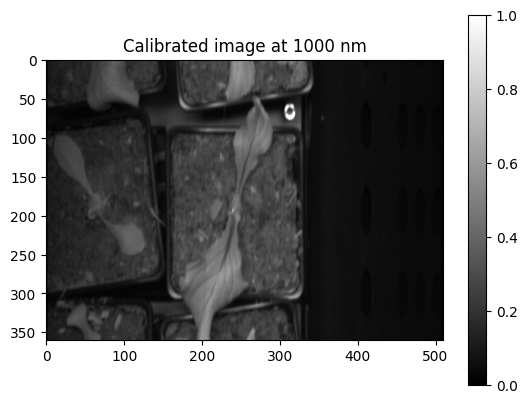

In [227]:
## Plot image at 1000~ wavelenth

print(wl1000.shape)  # (360, 510)
plt.imshow(wl1000, cmap='gray')
plt.title(f"Calibrated image at 1000 nm")
plt.colorbar()
plt.show()

In [228]:
#Load mask from file
mask = imread(f"{PATHinput}Mask.tif")  # load mask image
print(mask.shape)
print(mask.dtype)

mask_bool = mask > 0  # True where mask is not zero

(360, 510)
uint8


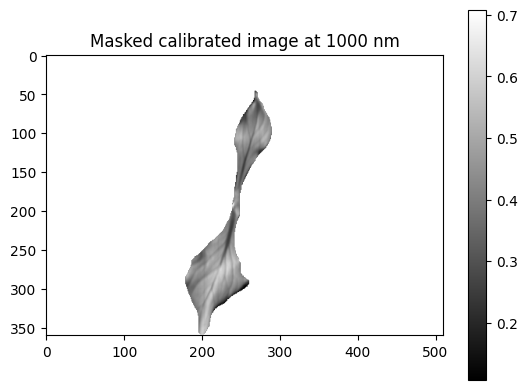

In [229]:
masked_image = np.where(mask_bool, wl1000, np.nan)  # np.nan where mask is False

plt.imshow(masked_image, cmap='gray')
plt.title(f"Masked calibrated image at 1000 nm")
plt.colorbar()
plt.show()

#Run the function on a folder containing several measurements.

In [280]:
# Input and output paths
PATHinput = '/content/drive/MyDrive/NPEC_notebooks/Hyperspectral/Input_Examples/Example900to1700wl/'
PATHoutput = '/content/drive/MyDrive/NPEC_notebooks/Hyperspectral/Output/'

# Pattern that separates measurement name from data label (e.g. data, dark, white)
#Example my file name is 31_12_2025-03-12_23-32-36_G8_1x1_square_537_SWIR_WhiteCalibration.hdr
#before SWIR is my measurement data after that is the type of data

FILE_NAME_key = "SWIR" #Note FILE_Name_key should be around _

Data_Suffix ='Data.bil'
White_Suffix = 'WhiteCalibration.bil'
Dark_Suffix = 'DarkCalibration.bil'

In [281]:
files = os.listdir(PATHinput)
groups = defaultdict(list)

for f in files:
    base, ext = os.path.splitext(f)
    parts = base.split('_')

    if FILE_NAME_key in parts:
        swir_index = parts.index(FILE_NAME_key)
        # Group key is everything before 'SWIR'
        group_key = '_'.join(parts[:swir_index])
        groups[group_key].append(f)

# === Parameters from your header info === These are usually all the same across PSI SWIR cameras
rows_data = 360
rows_cal = 5
cols = 510
bands = 318
start_wavelength = 901.465
end_wavelength = 1690.67

# Generate wavelengths vector
wavelengths = np.linspace(start_wavelength, end_wavelength, bands)
# Load BIL data function

def load_bil_data(PATHinput0, group_key0, FILE_NAME_key0, suffix0, rows, cols, bands):
    file_name0 = f'{PATHinput0}{group_key0}_{FILE_NAME_key0}_{suffix0}'
    data = np.fromfile(file_name0, dtype='<u2')  # little-endian uint16
    data = data.reshape((rows, bands, cols))
    return data

def find_band(target_wavelength):
    return np.argmin(np.abs(wavelengths - target_wavelength))


def save_tiff(img, filename):
    # tifffile.imwrite doesn't have dpi parameter, but we can embed metadata
    # Here we save raw array as 32-bit float (for precision)
    tifffile.imwrite(filename, img.astype('float32'))

def ImgParameters(PATHinput0, group_key0, FILE_NAME_key0, Data_Suffix0, Dark_Suffix0, White_Suffix0):
  # Load raw and calibration data
  raw = load_bil_data(PATHinput0, group_key0, FILE_NAME_key0, Data_Suffix0, rows_data, cols, bands)
  dark = load_bil_data(PATHinput0, group_key0, FILE_NAME_key0, Dark_Suffix0, rows_cal, cols, bands)
  white = load_bil_data(PATHinput0, group_key0,FILE_NAME_key0, White_Suffix0, rows_cal, cols, bands)
  #white
  white_avg_spectrum = white.mean(axis=(0, 2))
  white_cube_expanded = np.tile(white_avg_spectrum[np.newaxis, :, np.newaxis], (rows_data, 1, cols))
  #dark
  dark_avg_spectrum = dark.mean(axis=(0, 2))
  dark_cube_expanded = np.tile(dark_avg_spectrum[np.newaxis, :, np.newaxis], (rows_data, 1, cols))
  #calibration
  epsilon = 1e-8
  calibrated = (raw - dark_cube_expanded) / (white_cube_expanded - dark_cube_expanded + epsilon)
  calibrated = np.transpose(calibrated, (0, 2, 1))
  calibrated = np.clip(calibrated, 0, 1)
  #bands of interst
  nir_band = find_band(900)          # NIR (within 860–950 nm range)
  swir1_band = find_band(1250)       # SWIR1 (within 1230–1300 nm range)
  swir2_band = find_band(1650)       # SWIR2 (within 1600–1700 nm range)
  wl1000_band = find_band(1000)
  #filter data
  nir = calibrated[:, :, nir_band]   # shape: (360, 510)
  swir1 = calibrated[:, :, swir1_band]
  swir2 = calibrated[:, :, swir2_band]
  wl1000 = calibrated[:, :, wl1000_band]
  #Parameters images
  #NDWI: Normalized Difference Water Index
  ndwi = (nir - swir1) / (nir + swir1 + 1e-6)
  # MSI: Moisture Stress Index
  msi = swir1 / (nir + 1e-6)
  # NDII: Normalized Difference Infrared Index
  ndii = (nir - swir2) / (nir + swir2 + 1e-6)
  # Save each index
  save_tiff(ndwi, f'{PATHoutput}{group_key}ndwi.tiff')
  save_tiff(msi, f'{PATHoutput}{group_key}msi.tiff')
  save_tiff(ndii, f'{PATHoutput}{group_key}ndii.tiff')
  save_tiff(wl1000, f'{PATHoutput}{group_key}wl1000.tiff')
  print(f"Processed and saved indices for group: {group_key0}")

In [282]:
# Print groups info
for group_key, group_files in groups.items():
  print(group_key)
  ImgParameters(PATHinput, group_key, FILE_NAME_key, Data_Suffix, Dark_Suffix, White_Suffix)


31_12_2025-03-12_23-32-36_G8_1x1_square_537
Processed and saved indices for group: 31_12_2025-03-12_23-32-36_G8_1x1_square_537
31_12_2025-03-12_20-15-47_G8_1x1_square_302
Processed and saved indices for group: 31_12_2025-03-12_20-15-47_G8_1x1_square_302
